# Random Forests 1

---

__While the goals are to__:

- Improve sensitivity
- Consider the 12 possible representations
- Build random forest models
- Tune hyperparameters by conducting a grid search using cross validation
- Save results for later evaluation

__After some experimentation building random forests I found that__:

- The goals above are too lofty
- It takes too long to build random forests to test them on all 12 representations
- There are too many hyperparameters to tune: one needs a decision process to home in on the most promising ones
- Building simpler (shallower) forests yields lower scores: do params in shallower forests predict best params in deeper ones?

__This notebook simply serves as a POC for methods to optimize for sensitivity__:

I struggled with [Scikit-Learn's GridSearchCV](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/ensemble/_forest.py#L883) and my own DIY grid searches trying to optimize for sensitivity until I stubled upon Kevin Arvai's great tutorial [Fine tuning a classifier in scikit-learn](https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65). 

- Kevin Arvai introduces two strategies:
    1. GridSearchCV using the scoring argument
    2. Adjust the decision threshold to identify the operating point


- I'm conducting a POC of sorts by adapting Mr. Arvai's code here. Two changes so far:
    1. Because I've already set aside the holdout test set to avoid data leakage, any references to "test" below actually mean "validation" (set, error, etc.)
    2. In the first strategy, there's no need for the gridsearch wrapper: instead of running gridsearch all over again, we can just analyze the cv results and fit the model as desired.
    
__Performance Questions__:

- is running gridsearch on random forests in *Jupyter Notebooks* just a bad idea in general?
- is `GridSearchCV` just a slow way to perform gridsearch, would a simpler DIY search without so many params be faster?
- do fit times improve if we substitute *sparse matrices* for *numpy arrays*? Can we?

## Setup

In [1]:
import os
import re
import time
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt 
plt.style.use("ggplot")

from datetime import datetime
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-01-02


## Load Data

In [2]:
# load target
raw_path = os.path.join("data","1_raw")
filename = "y_train.csv"
y = pd.read_csv(os.path.join(raw_path, filename))
y = np.array(y.iloc[:,0].ravel())
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load 12 matrices
proc_dir = os.path.join("data","2_processed")
Xnames = [x for x in os.listdir(proc_dir) if re.search('.npz', x)]
Xs = []
for i, X in enumerate(Xnames):
    path_ = os.path.join(proc_dir, Xnames[i])
    Xs.append(sp.load_npz(path_))

## Grid search random forest models optimizing sensitivity


## Strategy 1: GridSearchCV

Using the Bag-of-Trigrams only. Remembering it had 98.59% accuracy, 90.69% sensitivity (the best), and 99.79% specificity with the logistic classifier, which ran fast and used all data. 

In [3]:
# Bag-of-upto-Trigrams (2,000 terms)
X_bot = Xs[0].toarray()

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_bot, y, stratify=y)

def check_target_distro(y_train, y_test):
    train_pos = y_train.sum() / len(y_train)
    val_pos = y_val.sum() / len(y_val)
    train_neg = 1 - train_pos
    val_neg = 1 - train_pos
    return {'train_pos':train_pos.round(3),
            'val_pos':val_pos.round(3),
            'train_neg':train_neg.round(3),
            'val_neg':val_neg.round(3)}

# check distribution of target 
check_target_distro(y_train, y_val)

{'train_pos': 0.133, 'val_pos': 0.132, 'train_neg': 0.867, 'val_neg': 0.867}

__Main RandomForestClassifier Hyperparameters__:

- *min_samples_split*: mininum number of samples required to split an internal node 
- *min_samples_leaf*: minimum number of samples required at a leaf node
- *n_estimators*: number of trees
- *max_depth*: maximum depth of trees
- *max_features*: maximum number of features in a tree, known as `mtry` in the literature and in R
- *criterion*: the information gain criterion, gini or entropy

There are many others, [see sklearn.ensemble.RandomForestClassifier docs.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [4]:
# instantiate estimator, set seed for reproducibility
clf = RandomForestClassifier(n_jobs=-1, random_state=42)

# setup shallow grid of params
param_grid_shallow = {
    'min_samples_split': [10, 25, 50], 
    'n_estimators' : [50, 100, 200],
    'max_depth': [3, 5, 10],
    'max_features': [10, 50, 100, 250]
}

# setup scorers
scorers = {
    'acc': make_scorer(accuracy_score),
    'tpr': make_scorer(recall_score, pos_label=1), # sensitivity, recall
    'tnr': make_scorer(recall_score, pos_label=0) # specificity, selectivity
}

### 5-fold CV optimizing sensitivity with `refit`

In [5]:
cv_folds = StratifiedKFold(n_splits=5)
grid_search_clf = GridSearchCV(clf, param_grid_shallow, scoring=scorers, refit='tpr', 
                               cv=cv_folds, return_train_score=True, n_jobs=-1)

In [6]:
start_gs = time.time()

grid_search_clf.fit(X_train, y_train)

mins, secs = divmod(time.time() - start_gs, 60)
print(f'\nElapsed: {mins:0.0f} m {secs:0.0f} s')


Elapsed: 4 m 3 s


In [7]:
# predict
y_pred = grid_search_clf.predict(X_val)
grid_search_clf.best_params_

{'max_depth': 10,
 'max_features': 250,
 'min_samples_split': 10,
 'n_estimators': 100}

In [8]:
# confusion matrix on validation set
print(pd.DataFrame(confusion_matrix(y_val, y_pred),
                   columns=['pred_neg', 'pred_pos'],
                   index=['neg', 'pos']))

     pred_neg  pred_pos
neg       839         7
pos        21       108


In [9]:
def print_eval_metrics(y_val, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    print(f'accuracy: {acc:0.4f}')
    print(f'sensitivity: {tpr:0.4f}')
    print(f'specificity: {tnr:0.4f}')

print_eval_metrics(y_val, y_pred)

accuracy: 0.9713
sensitivity: 0.8372
specificity: 0.9917


In [29]:
def format_results(gridsearch, sort_by):
    res_df = pd.DataFrame(gridsearch.cv_results_)
    res_df = res_df[['mean_test_acc', 'mean_test_tpr', 'mean_test_tnr', 
                     'param_max_depth', 'param_max_features', 
                     'param_min_samples_split', 'param_n_estimators'
                    ]]
    res_df = res_df.sort_values(by=sort_by, ascending=False).round(3).head()
    res_df = res_df.rename(
        columns={"mean_test_acc": "mean_val_acc", "mean_test_tpr": "mean_val_tpr", 
                 "mean_test_tnr":"mean_val_tnr", "param_max_depth":"max_depth", 
                 "param_max_features":"max_features", "param_min_samples_split":"min_samples_split", 
                 "param_n_estimators":"n_estimators"
                })
    return res_df

# top  results by mean validation sensitivity (desc)
format_results(grid_search_clf, 'mean_test_tpr')

,mean_val_acc,mean_val_tpr,mean_val_tnr,max_depth,max_features,min_samples_split,n_estimators
100,0.979,0.863,0.997,10,250,10,100
99,0.978,0.861,0.996,10,250,10,50
102,0.978,0.858,0.996,10,250,25,50
101,0.979,0.858,0.997,10,250,10,200
105,0.977,0.856,0.996,10,250,50,50


##  Deeper gridsearch

In [35]:
# deeper params
param_grid_deep = {
    'min_samples_split': [10, 20], 
    'n_estimators' : [500],
    'max_depth': [10, 20],
    'max_features': [500]
}

In [36]:
grid_search_clf_deep = GridSearchCV(clf, param_grid_deep, scoring=scorers, refit='tpr', 
                                    cv=cv_folds, return_train_score=True, n_jobs=-1)

In [37]:
start_gs = time.time()

grid_search_clf_deep.fit(X_train, y_train)

mins, secs = divmod(time.time() - start_gs, 60)
print(f'\nElapsed: {mins:0.0f} m {secs:0.0f} s')


Elapsed: 5 m 42 s


In [38]:
# predict
y_pred = grid_search_clf_deep.predict(X_val)
grid_search_clf_deep.best_params_

{'max_depth': 20,
 'max_features': 500,
 'min_samples_split': 10,
 'n_estimators': 500}

In [39]:
# confusion matrix on validation set
print(pd.DataFrame(confusion_matrix(y_val, y_pred),
                   columns=['pred_neg', 'pred_pos'],
                   index=['neg', 'pos']))

     pred_neg  pred_pos
neg       840         6
pos        18       111


In [40]:
print_eval_metrics(y_val, y_pred)

accuracy: 0.9754
sensitivity: 0.8605
specificity: 0.9929


In [41]:
format_results(grid_search_clf_deep, 'mean_test_tpr')

,mean_val_acc,mean_val_tpr,mean_val_tnr,max_depth,max_features,min_samples_split,n_estimators
2,0.981,0.884,0.996,20,500,10,500
3,0.981,0.884,0.995,20,500,20,500
0,0.980,0.876,0.996,10,500,10,500
1,0.980,0.876,0.996,10,500,20,500



## Strategy 2: Adjust the decision threshold to identify the operating point

From Mr. Arvai's tutorial (my bold):

>The `precision_recall_curve` and `roc_curve` are useful tools to visualize the __sensitivity-specificty tradeoff__ in the classifier. They help inform a data scientist where to set the __decision threshold__ of the model to maximize either sensitivity or specificity. This is called the __“operating point”__ of the model.

>The key to understanding how to fine tune classifiers in scikit-learn is to understand the methods `.predict_proba()` and `.decision_function()`. These return the __raw probability__ that a sample is predicted to be in a class. This is an important distinction from the __absolute class predictions__ returned by calling the `.predict()` method.

We start by creating an array of possible class scores.

In [42]:
# possible scores
# certain classifiers, like SVC, user the .decision_function() method
y_scores = grid_search_clf.predict_proba(X_val)[:, 1] # second col = prob of pos

In [43]:
# generate precision-recall curve
p, r, thresholds = precision_recall_curve(y_val, y_scores)

In [44]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix
    y_pred_adj = adjusted_classes(y_scores, t)
    
    # print confusion matrix
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_val, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])) 
    
    # print eval metrics
    print('\nEvaluation metrics:')
    print_eval_metrics(y_val, y_pred_adj)
    
    # plot the curve
    plt.figure(figsize=(5, 5))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='r', alpha=0.8, where='post')
    plt.fill_between(r, p, step='post', alpha=0.1, color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k', markersize=12)

Re-execute the `precision_recall_threshold` function for several iterations, changing `t` each time, to tune the threshold until there are 0 False Negatives.

Confusion Matrix:
     pred_neg  pred_pos
neg       839         7
pos        21       108

Evaluation metrics:
accuracy: 0.9713
sensitivity: 0.8372
specificity: 0.9917


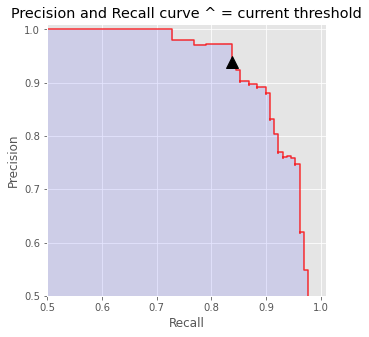

In [45]:
precision_recall_threshold(p, r, thresholds, 0.50)

Confusion Matrix:
     pred_neg  pred_pos
neg       834        12
pos        18       111

Evaluation metrics:
accuracy: 0.9692
sensitivity: 0.8605
specificity: 0.9858


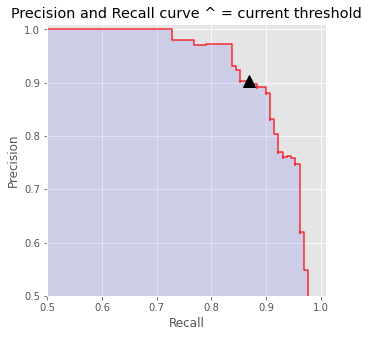

In [46]:
precision_recall_threshold(p, r, thresholds, 0.40)

Confusion Matrix:
     pred_neg  pred_pos
neg       832        14
pos        14       115

Evaluation metrics:
accuracy: 0.9713
sensitivity: 0.8915
specificity: 0.9835


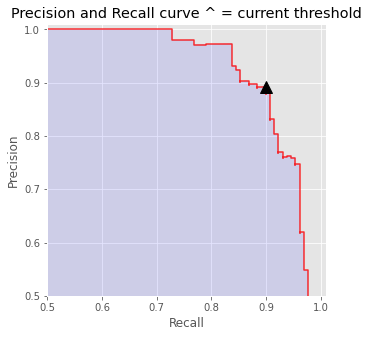

In [47]:
precision_recall_threshold(p, r, thresholds, 0.30)

Confusion Matrix:
     pred_neg  pred_pos
neg       818        28
pos        11       118

Evaluation metrics:
accuracy: 0.9600
sensitivity: 0.9147
specificity: 0.9669


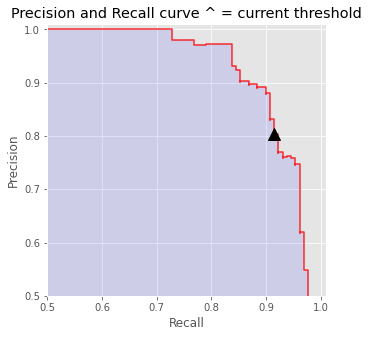

In [48]:
precision_recall_threshold(p, r, thresholds, 0.20)

---